# Example 6: Non-linear PCA 


<a href="https://colab.research.google.com/github/PGM-Lab/ProbModelingDNNs/blob/master/notebooks/Example6-NLPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


A non-linear principal component analysis (NLPCA) is quite similar to the standard PCA model presented in Example 1. The main difference comes
from the conditional distribution of $\boldsymbol{x}$. In the NLPCA model, the mean of the normal distribution of $\boldsymbol{x}$
linearly depends  on $\boldsymbol{z}$ through $\boldsymbol{\beta}$. In the such model, the mean depends on $\boldsymbol{z}$ through a DNN
parametrized by $\boldsymbol{\beta}$. This DNN is also known as the decoder network (Kingma & Welling, 2013).

The pseudo-code blow provides a description of the generative model of a NLPCA. 


<img src="https://raw.githubusercontent.com/PGM-Lab/ProbModelingDNNs/master/img/nlpca_pseudocode.png" alt="PCA-pseudocode" style="width: 700px;"/>

The present notebook experimentally illustrates the behavior of a NLPCA as a feature reduction method on (a reduced version of) MNIST dataset. The model is implemented using the Edward2 from tensorflow-probability. Note that the generative model is identical to the one in a variational auto-encoder, whcih is presented in a separated notebook.

## Setting up the system

First, we will install and import the required packages as follows.



In [1]:
!pip install tensorflow
!pip install tensorflow-probability
!pip install keras
!pip install matplotlib
!pip install inferpy==1.1.0
!pip install setuptools
!pip install pandas

In [2]:
import tensorflow as tf
from tensorflow_probability import edward2 as ed
import numpy as np
import matplotlib.pyplot as plt
import inferpy as inf
from inferpy.datasets import mnist
import pandas as pd

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Global configuration
num_epochs = 3000
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01


Using TensorFlow backend.


## Data 

For illustrating purposes, the MNIST dataset containg handwritten digits will be used. In particular we might obtain the data from the ``inferpy`` package (and hence from keras):

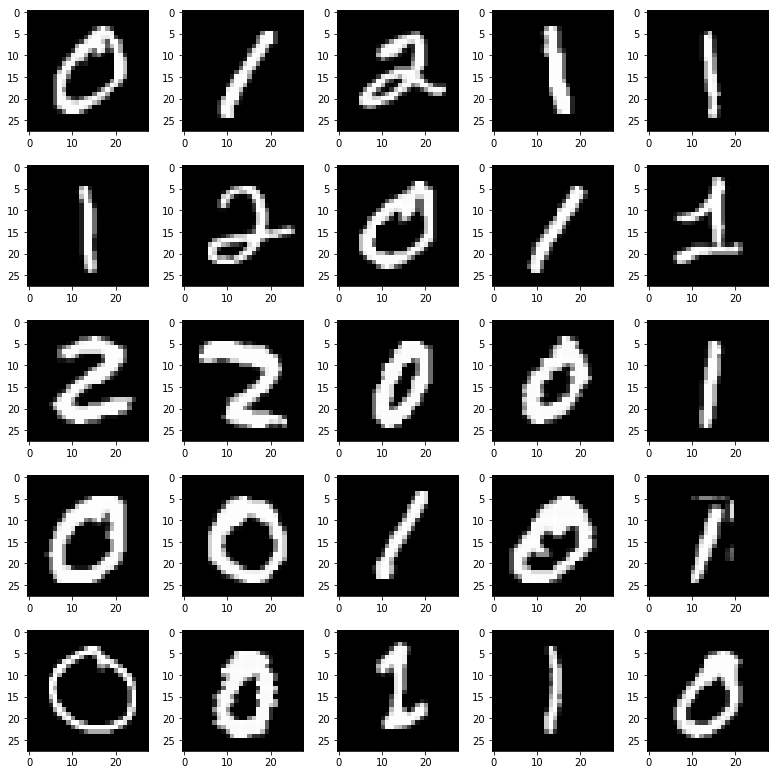

In [3]:
# number of observations (dataset size)
N = 1000
# digits considered
DIG = [0,1,2]

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

# plot the digits
mnist.plot_digits(x_train, grid=[5,5])

### Model definition

The implementation for the generative model for a NLPCA model (Algorithm 3) is defined below. The input parameters are: `k` is the latent dimension, `d` is the data-dimension and `N`the number of samples or data instances. 

In [4]:
# Model constants
k, d0, d1 = 2, 100, np.shape(x_train)[-1]

# initial values
loc_init = 0.001
scale_init = 1


def nlpca(k, d0, d1, N, decoder):

    # Define local latent variables
    z = ed.Normal(loc=tf.ones([k]), scale=1., sample_shape=N, name="z")

    output, weights = decoder(z, k, d0, d1)

    # Define the observed variables
    x = ed.Normal(loc=output, scale=1., name="x")

    return z, weights, x


def decoder(z, k, d0, d1):

    beta0 = ed.Normal(tf.ones([k, d0]) * loc_init, scale_init, name="beta0")
    alpha0 = ed.Normal(tf.ones([d0]) * loc_init, scale_init, name="alpha0")

    h0 = tf.nn.relu(z @ beta0 + alpha0, name="h0")

    ######

    beta1 = ed.Normal(tf.ones([d0, d1]) * loc_init, scale_init, name="beta1")
    alpha1 = ed.Normal(tf.ones([d1]) * loc_init, scale_init, name="alpha1")

    output = h0 @ beta1 + alpha1

    return output, (beta0, alpha0, beta1, alpha1)




print(nlpca)
print(decoder)

<function nlpca at 0x1297fac80>
<function decoder at 0x1297fad90>


This is a latent varable model (LVM) containing DNNs where the latent representation $\boldsymbol{z}$ is known as the scores, and the affine transformation is performed using a DNN parametrized by $\boldsymbol{\beta}$ and $\boldsymbol{\alpha}$.

### Inference

Variational inference is a deterministic technique that finds a tractable approximation to an intractable (posterior) distribution. 
We will use $q$ to denote the approximation, and use $p$ to signify the true distribution (like $p(\boldsymbol{\beta, \alpha},\boldsymbol{z}|\boldsymbol{x})$ in the example above).
More specifically, ${\cal Q}$ will denote a set of possible approximations $q$.

In practice, we define a generative model for sampling from $q(\boldsymbol{\beta, \alpha},\boldsymbol{z} | \boldsymbol{\lambda}, \boldsymbol{\phi})$, where $\boldsymbol{\lambda}, \boldsymbol{\phi}$ are the variational parameters to optimise.





In [5]:
def Q(k, d0, d1):

    qz_loc = tf.Variable(tf.ones([N, k]))
    qz_scale = tf.math.softplus(tf.Variable(tf.ones([N, k])))
    qz = ed.Normal(loc=qz_loc, scale=qz_scale, name="qz")

    ###

    qbeta0_loc = tf.Variable(tf.ones([k, d0]) * loc_init, name="qbeta0_loc")
    qbeta0_scale = tf.math.softplus(tf.Variable(tf.ones([k, d0]) * scale_init, name="qbeta0_scale"))
    qbeta0 = ed.Normal(qbeta0_loc, qbeta0_scale, name="qbeta0")

    qalpha0_loc = tf.Variable(tf.ones([d0]) * loc_init, name="qalpha0_loc")
    qalpha0_scale = tf.math.softplus(tf.Variable(tf.ones([d0]) * scale_init, name="qalpha0_scale"))
    qalpha0 = ed.Normal(qalpha0_loc, qalpha0_scale, name="qalpha0")

    ###

    qbeta1_loc = tf.Variable(tf.ones([d0, d1]) * loc_init, name="qbeta1_loc")
    qbeta1_scale = tf.math.softplus(tf.Variable(tf.ones([d0, d1]) * scale_init, name="qbeta1_scale"))
    qbeta1 = ed.Normal(qbeta1_loc, qbeta1_scale, name="qbeta1")

    qalpha1_loc = tf.Variable(tf.ones([d1]) * loc_init, name="qalpha1_loc")
    qalpha1_scale = tf.math.softplus(tf.Variable(tf.ones([d1]) * scale_init, name="qalpha1_scale"))
    qalpha1 = ed.Normal(qalpha1_loc, qalpha1_scale, name="qalpha1")

    ###

    return qz, (qbeta0, qalpha0, qbeta1, qalpha1)


print(Q)

<function Q at 0x130667c80>


Variational methods adjusts the parameters by maximizing the ELBO (Evidence LOwer Bound) denoted $\cal{L}$ and expressed as 

$\cal{L}(\boldsymbol{\lambda},\boldsymbol{\phi})  = \mathbb{E}_q [\ln p(\boldsymbol{x}, \boldsymbol{z}, \boldsymbol{\beta, \alpha})] - \mathbb{E}_q [\ln q(\boldsymbol{\beta, \alpha},\boldsymbol{z}|\boldsymbol{\lambda},\boldsymbol{\phi})]$

In Edward, this is done as follows.

In [6]:
def set_values(**model_kwargs):
    """Creates a value-setting interceptor."""
    def interceptor(f, *args, **kwargs):
        """Sets random variable values to its aligned value."""
        name = kwargs.get("name")
        if name in model_kwargs:
            kwargs["value"] = model_kwargs[name]
        else:
            print(f"set_values not interested in {name}.")
        return ed.interceptable(f)(*args, **kwargs)
    return interceptor


qz, qw = Q(k, d0, d1)

qw_dict = {v.distribution.name.split("_")[0].split("/")[0][1:]: v for v in qw}


with ed.interception(set_values(z=qz, x=x_train, **qw_dict)):
    pz, pw, px = nlpca(k, d0, d1, N, decoder)

energy = tf.reduce_sum(pz.distribution.log_prob(pz.value)) + \
         tf.reduce_sum(px.distribution.log_prob(px.value)) + \
         tf.reduce_sum([tf.reduce_sum(v.distribution.log_prob(v.value)) for v in pw])

entropy = tf.reduce_sum(qz.distribution.log_prob(qz.value)) + \
          tf.reduce_sum([tf.reduce_sum(v.distribution.log_prob(v.value)) for v in qw])

elbo = energy - entropy

print(elbo)

Tensor("sub:0", shape=(), dtype=float32)


Finally, the ELBO function is maximized.

In [7]:
with tf.Session() as sess:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    t = []
    train = optimizer.minimize(-elbo)
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(num_epochs+1):
        t.append(sess.run(elbo))
        sess.run(train)
        if verbose:
            if i % 10 == 0: print(".", end="", flush=True)
            if i % 100 == 0:
                str_elbo = str(t[-1] / 1000) + " k"
                print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)

    # extract the inferred parameters
    postw = {k: sess.run(v) for k, v in qw_dict.items()}
    post = {"z": sess.run(qz.distribution.loc), **postw}
    
# save the ELBO evolution
data = pd.DataFrame({"elbo": t})
data.to_csv(f"./res/elbo_nlpca.csv")

.
0 epochs	-3292558.336 k..........
100 epochs	-2169640.96 k..........
200 epochs	-1905051.136 k..........
300 epochs	-1832696.32 k..........
400 epochs	-1773229.824 k..........
500 epochs	-1723909.888 k..........
600 epochs	-1623801.344 k..........
700 epochs	-1485210.24 k..........
800 epochs	-1425980.288 k..........
900 epochs	-1366520.192 k..........
1000 epochs	-1303033.088 k..........
1100 epochs	-1244850.56 k..........
1200 epochs	-1216890.752 k..........
1300 epochs	-1190127.488 k..........
1400 epochs	-1177156.096 k..........
1500 epochs	-1167780.48 k..........
1600 epochs	-1153971.584 k..........
1700 epochs	-1119988.736 k..........
1800 epochs	-1084378.368 k..........
1900 epochs	-1052892.352 k..........
2000 epochs	-1025623.68 k..........
2100 epochs	-1005798.4 k..........
2200 epochs	-989535.744 k..........
2300 epochs	-983751.104 k..........
2400 epochs	-973624.384 k..........
2500 epochs	-964685.76 k..........
2600 epochs	-959170.24 k..........
2700 epochs	-950401.856 k.

After the inference, we can plot the hidden representation:

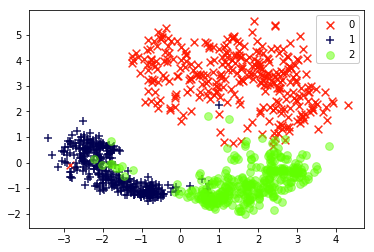

In [8]:
markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], post["z"][y_train == DIG[c], 1], color=col,
                label=DIG[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend(loc='upper right',framealpha=1)
fig.savefig("../img/pca_nolineal_mnist.pdf")

## Test

For testing our model, we will generate samples of $\boldsymbol{x}$ given the infered posterior distributions.

set_values not interested in x.


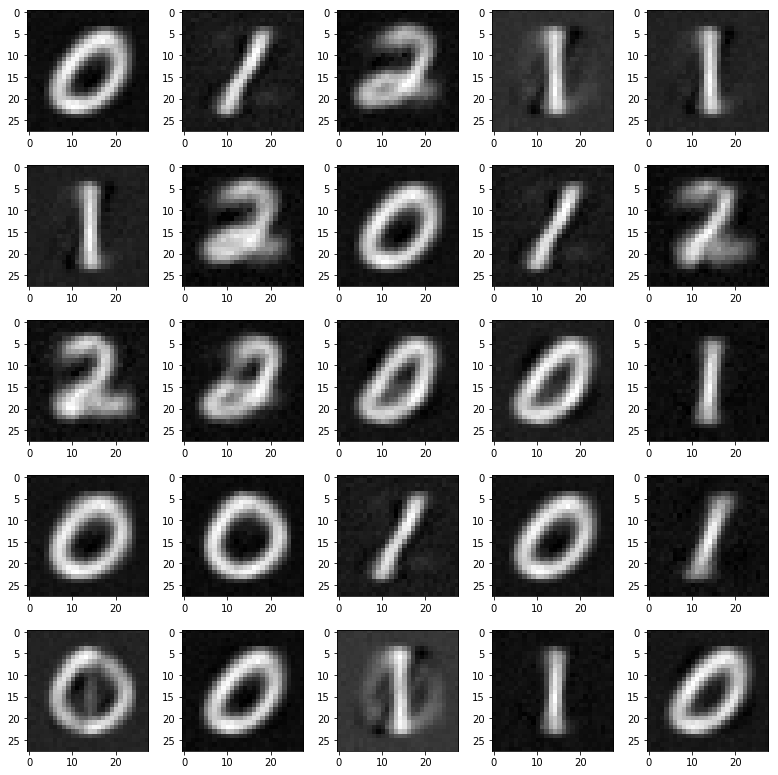

In [9]:
with ed.interception(set_values(**post)):
    generate = nlpca(k, d0, d1, N, decoder)

with tf.Session() as sess:
    _, _, x_gen = sess.run(generate)
    
# plot the digits
mnist.plot_digits(x_gen, grid=[5,5])